
# SmartCart: E-Commerce Recommender System & Pattern Mining

## Overview
 This notebook implements:
 1. Data preprocessing and exploration
 2. User-based collaborative filtering with cosine similarity
 3. Association rule mining using Apriori algorithm
 4. Analysis and visualization of results

## Part 1: Data Preprocessing

In [24]:
# Import Required Libraries
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

### Load and Explore Datasets

In [25]:
# Load the datasets
user_data = pd.read_csv('ecommerce_user_data.csv')
product_data = pd.read_csv('product_details.csv')

# Display sample data
print("E-commerce Data Sample:")
display(user_data.head(10))
print("\nProduct Details Sample:")
display(product_data.head(10))

# Basic info
print("\nUser Data Info:")
print(user_data.info())
print("\nProduct Data Info:")
print(product_data.info())

E-commerce Data Sample:


,UserID,ProductID,Rating,Timestamp,Category
0,U000,P0009,5,2024-09-08,Books
1,U000,P0020,1,2024-09-02,Home
2,U000,P0012,4,2024-10-18,Books
3,U000,P0013,1,2024-09-18,Clothing
4,U000,P0070,4,2024-09-16,Toys
5,U000,P0014,1,2024-09-15,Home
6,U000,P0048,5,2024-09-09,Toys
7,U000,P0079,4,2024-10-18,Electronics
8,U000,P0042,3,2024-09-07,Toys
9,U000,P0050,1,2024-10-14,Clothing



Product Details Sample:


,ProductID,ProductName,Category
0,P0000,Toys Item 0,Clothing
1,P0001,Clothing Item 1,Electronics
2,P0002,Books Item 2,Electronics
3,P0003,Clothing Item 3,Electronics
4,P0004,Clothing Item 4,Electronics
5,P0005,Home Item 5,Toys
6,P0006,Books Item 6,Books
7,P0007,Books Item 7,Books
8,P0008,Books Item 8,Electronics
9,P0009,Clothing Item 9,Books



User Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   UserID     724 non-null    object
 1   ProductID  724 non-null    object
 2   Rating     724 non-null    int64 
 3   Timestamp  724 non-null    object
 4   Category   724 non-null    object
dtypes: int64(1), object(4)
memory usage: 28.4+ KB
None

Product Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ProductID    100 non-null    object
 1   ProductName  100 non-null    object
 2   Category     100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB
None


### Data Cleaning and Transformation

In [26]:
# Merge product names into user data
merged_data = pd.merge(user_data, product_data, on='ProductID')

# Handle missing values
print("\n=== Cleaning Steps ===")
print(f"Before cleaning - Missing values:\n{merged_data.isnull().sum()}")

# Strategy: Fill missing ratings with 0 (no interaction)
merged_data['Rating'] = merged_data['Rating'].fillna(0)

# Convert timestamp to datetime
merged_data['Timestamp'] = pd.to_datetime(merged_data['Timestamp'], errors='coerce')


# Create user-item matrix
user_item_matrix = merged_data.pivot_table(
    index='UserID',
    columns='ProductID',
    values='Rating',
    fill_value=0
)

print("\n=== Processed Data ===")
print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
print("\nSample from User-Item Matrix:")
display(user_item_matrix.iloc[:10, :10])


=== Cleaning Steps ===
Before cleaning - Missing values:
UserID         0
ProductID      0
Rating         0
Timestamp      0
Category_x     0
ProductName    0
Category_y     0
dtype: int64

=== Processed Data ===
User-Item Matrix Shape: (50, 100)

Sample from User-Item Matrix:


ProductID,P0000,P0001,P0002,P0003,P0004,P0005,P0006,P0007,P0008,P0009
UserID,,,,,,,,,,
U000,0.0,0.0,0.0,3.0,0.0,5.0,0.0,3.0,0.0,5.0
U001,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U002,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
U003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U004,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
U005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U006,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
U007,2.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
U008,0.0,0.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,4.0


### Feature Engineering

In [27]:
# Add aggregated features
merged_data['Interaction_Count'] = merged_data.groupby('UserID')['ProductID'].transform('count')
merged_data['Avg_Rating'] = merged_data.groupby('UserID')['Rating'].transform('mean')

# Categorize users based on activity
merged_data['User_Type'] = pd.cut(
    merged_data['Interaction_Count'],
    bins=[0, 5, 20, float('inf')],
    labels=['Casual', 'Active', 'Power']
)

print("\n=== Engineered Features ===")
print(merged_data[['UserID', 'Interaction_Count', 'Avg_Rating', 'User_Type']].drop_duplicates().head())


=== Engineered Features ===
   UserID  Interaction_Count  Avg_Rating User_Type
0    U000                 20    3.050000    Active
20   U001                 13    2.923077    Active
33   U002                 14    2.428571    Active
47   U003                 11    2.181818    Active
58   U004                 17    2.941176    Active


## Part 2: Collaborative Filtering with Cosine Similarity

### Create Train-Test Split

In [28]:
# Get all active users (with at least 1 interaction)
active_users = user_item_matrix[user_item_matrix.sum(axis=1) > 0].index

# Filter matrix to only active users
user_item_matrix = user_item_matrix.loc[active_users]

# Split while preserving all users in training
train_data, test_data = train_test_split(
    user_item_matrix,
    test_size=0.2,
    random_state=42,
    stratify=user_item_matrix.any(axis=1)  # Preserve users with/without interactions
)

print("=== Data Split ===")
print(f"Training Users: {train_data.shape[0]}")
print(f"Test Users: {test_data.shape[0]}")

# Ensure no test users are completely new
#assert set(test_data.index).issubset(set(train_data.index)), "Test users missing from training!"

=== Data Split ===
Training Users: 40
Test Users: 10


### Calculate User Similarity

In [29]:
# Convert to sparse format for efficiency
train_sparse = csr_matrix(train_data.values)

# Compute cosine similarities
user_similarity = cosine_similarity(train_sparse)
user_sim_df = pd.DataFrame(
    user_similarity,
    index=train_data.index,
    columns=train_data.index
)

print("\n=== Similarity Matrix ===")
print("Sample Similarities (First 10 Users):")
display(user_sim_df.iloc[:10, :10])


=== Similarity Matrix ===
Sample Similarities (First 10 Users):


UserID,U030,U013,U023,U011,U037,U047,U012,U009,U017,U006
UserID,,,,,,,,,,
U030,1.000000,0.088251,0.309603,0.141478,0.084334,0.335087,0.071263,0.026251,0.112091,0.094732
U013,0.088251,1.000000,0.138868,0.063893,0.166509,0.054554,0.084116,0.179712,0.199931,0.227074
U023,0.309603,0.138868,1.000000,0.142642,0.317475,0.191390,0.118039,0.000000,0.061889,0.090526
U011,0.141478,0.063893,0.142642,1.000000,0.201843,0.000000,0.238429,0.082068,0.233624,0.167866
U037,0.084334,0.166509,0.317475,0.201843,1.000000,0.104267,0.014615,0.107672,0.209448,0.125535
U047,0.335087,0.054554,0.191390,0.000000,0.104267,1.000000,0.058738,0.121706,0.138585,0.153159
U012,0.071263,0.084116,0.118039,0.238429,0.014615,0.058738,1.000000,0.029191,0.126625,0.092608
U009,0.026251,0.179712,0.000000,0.082068,0.107672,0.121706,0.029191,1.000000,0.056847,0.081872
U017,0.112091,0.199931,0.061889,0.233624,0.209448,0.138585,0.126625,0.056847,1.000000,0.262198


### Generate Recommendations

In [30]:
def get_recommendations(user_id, n_similar=5, top_n=5, verbose=False):
    """
    Robust recommendation function with:
    - Similar user selection
    - Unrated product filtering
    - Fallback mechanisms
    """
    # Input validation
    if user_id not in train_data.index:
        if verbose:
            print(f"User {user_id} not in training data - returning popular items")
        return user_item_matrix.mean().sort_values(ascending=False).head(top_n).index.tolist()

    try:
        # Get most similar users (excluding self)
        similar_users = user_sim_df[user_id].sort_values(ascending=False)[1:n_similar+1].index

        # Find unrated products
        user_ratings = train_data.loc[user_id]
        unrated_mask = (user_ratings == 0)
        unrated_products = user_ratings[unrated_mask].index

        if len(unrated_products) == 0:
            if verbose:
                print(f"User {user_id} has rated all products - returning top global items")
            return user_item_matrix.mean().sort_values(ascending=False).head(top_n).index.tolist()

        # Calculate weighted recommendations
        similar_users_ratings = train_data.loc[similar_users, unrated_products]
        recommendations = similar_users_ratings.mean(axis=0).sort_values(ascending=False)

        return recommendations.head(top_n).index.tolist()

    except Exception as e:
        print(f"Error generating recommendations for {user_id}: {str(e)}")
        return []

# Test the function
sample_user = train_data.index[0]
print(f"\nSample Recommendations for User {sample_user}:")
print(get_recommendations(sample_user, verbose=True))


Sample Recommendations for User U030:
['P0003', 'P0088', 'P0089', 'P0049', 'P0051']


### Evaluate Recommendations

In [31]:
def evaluate_recommendations(test_users, k=5):
    """
    Comprehensive evaluation with:
    - Precision@K
    - Recall@K
    - Coverage
    - Diversity
    """
    metrics = {
        'precision': [],
        'recall': [],
        'coverage': set(),
        'diversity': []
    }

    for user in test_users:
        # Get ground truth
        actual_positives = set(test_data.loc[user][test_data.loc[user] > 0].index)
        if len(actual_positives) == 0:
            continue

        # Get recommendations
        recommended = get_recommendations(user, top_n=k)
        if not recommended:
            continue

        # Convert to set for operations
        recommended_set = set(recommended)

        # Calculate metrics
        true_positives = len(actual_positives & recommended_set)
        metrics['precision'].append(true_positives / k)
        metrics['recall'].append(true_positives / len(actual_positives))
        metrics['coverage'].update(recommended_set)

        # Calculate pairwise diversity (if multiple recommendations)
        if len(recommended) > 1:
            item_similarity = cosine_similarity(user_item_matrix[list(recommended)].T)
            upper_tri = np.triu_indices(item_similarity.shape[0], k=1)
            metrics['diversity'].append(1 - np.mean(item_similarity[upper_tri]))

    # Aggregate results
    results = {
        'precision@k': np.mean(metrics['precision']),
        'recall@k': np.mean(metrics['recall']),
        'coverage': len(metrics['coverage']) / user_item_matrix.shape[1],
        'diversity': np.mean(metrics['diversity']) if metrics['diversity'] else 0
    }

    return results

# Run evaluation
test_users_sample = test_data.sample(min(50, len(test_data)), random_state=42).index
eval_results = evaluate_recommendations(test_users_sample)

print("\n=== Evaluation Results ===")
for metric, value in eval_results.items():
    print(f"{metric:>12}: {value:.4f}")


=== Evaluation Results ===
 precision@k: 0.3000
    recall@k: 0.1051
    coverage: 0.0500
   diversity: 0.8048


## Part 3 - Association Rule Mining (Apriori)

###Transaction Preparation

In [32]:
# Create transaction lists
transactions = (
    merged_data[merged_data['Rating'] > 0]
    .groupby('UserID')['ProductID']
    .apply(list)
    .values
    .tolist()
)

# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

print("\n=== Transaction Matrix ===")
print(f"Shape: {transaction_df.shape}")
print("Sample Transactions:")
display(transaction_df.iloc[:10, :10].astype(int))


=== Transaction Matrix ===
Shape: (50, 100)
Sample Transactions:


,P0000,P0001,P0002,P0003,P0004,P0005,P0006,P0007,P0008,P0009
0,0,0,0,1,0,1,0,1,0,1
1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,1,0,1,0,0,0,0,0,1,0
8,0,0,1,1,1,0,0,0,0,1
9,0,0,1,0,0,0,0,1,0,0


###Frequent Itemset Mining

In [33]:
# Find frequent itemsets
frequent_itemsets = apriori(
    transaction_df,
    min_support=0.01,
    use_colnames=True,
    max_len=3,
    verbose=1
)

# Add length information
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)

print("\nTop 10 Frequent Itemsets:")
display(
    frequent_itemsets.sort_values('support', ascending=False)
    .head(10)
    .style.background_gradient(cmap='Blues')
)

Processing 324675 combinations | Sampling itemset size 3

Top 10 Frequent Itemsets:


,support,itemsets,length
70,0.340000,frozenset({'P0070'}),1
89,0.260000,frozenset({'P0089'}),1
51,0.260000,frozenset({'P0051'}),1
88,0.240000,frozenset({'P0088'}),1
43,0.240000,frozenset({'P0043'}),1
65,0.220000,frozenset({'P0065'}),1
30,0.220000,frozenset({'P0030'}),1
77,0.220000,frozenset({'P0077'}),1
44,0.220000,frozenset({'P0044'}),1
4,0.220000,frozenset({'P0004'}),1


###Rule Generation & Analysis

In [34]:
# Generate association rules
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0  # Only meaningful positive associations
).sort_values('lift', ascending=False)

# Add readable product names
rules['antecedent_names'] = rules['antecedents'].apply(
    lambda x: [product_data.loc[product_data['ProductID'] == pid, 'ProductName'].values[0] for pid in x]
)
rules['consequent_names'] = rules['consequents'].apply(
    lambda x: [product_data.loc[product_data['ProductID'] == pid, 'ProductName'].values[0] for pid in x]
)

print("\nTop 5 Association Rules by Lift:")
display(
    rules.head(5)[
        ['antecedent_names', 'consequent_names', 'support', 'confidence', 'lift']
    ].style.background_gradient(subset=['support', 'confidence', 'lift'], cmap='YlOrRd')
)


Top 5 Association Rules by Lift:


,antecedent_names,consequent_names,support,confidence,lift
55754,"['Beauty Item 12', 'Toys Item 60']",['Electronics Item 27'],0.020000,1.000000,25.000000
55762,['Electronics Item 27'],"['Beauty Item 63', 'Beauty Item 12']",0.020000,0.500000,25.000000
55723,"['Electronics Item 40', 'Beauty Item 12']",['Electronics Item 27'],0.040000,1.000000,25.000000
55726,['Electronics Item 27'],"['Electronics Item 40', 'Beauty Item 12']",0.040000,1.000000,25.000000
91469,['Electronics Item 27'],"['Beauty Item 83', 'Home Item 80']",0.020000,0.500000,25.000000


###Visualization

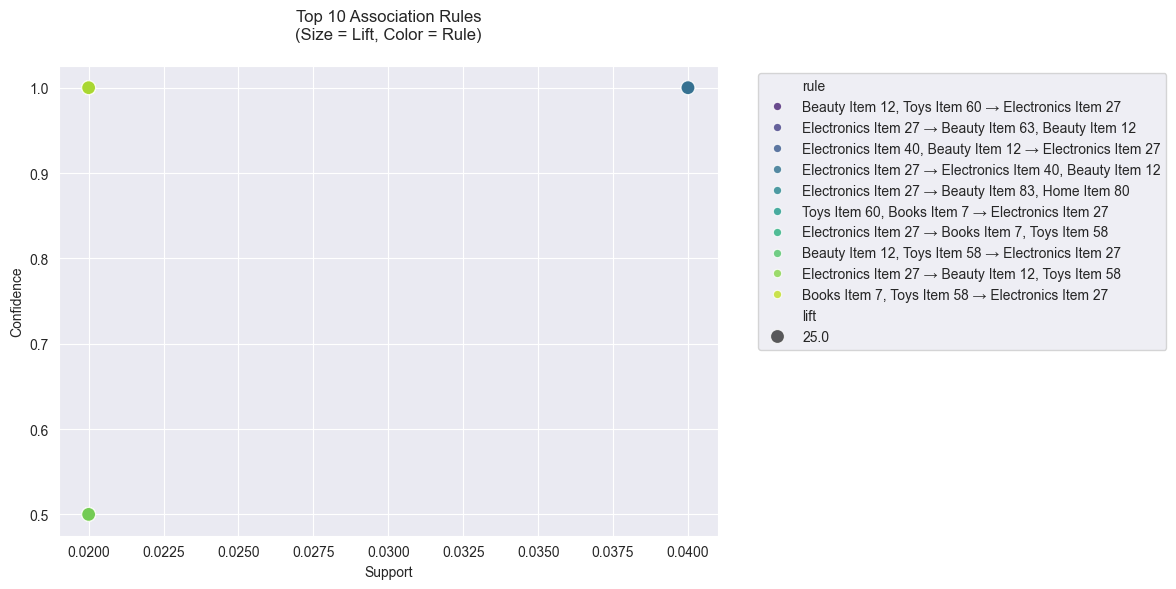

In [35]:
# Plot top rules
plt.figure(figsize=(12, 6))
top_rules = rules.head(10).copy()
top_rules['rule'] = top_rules.apply(
    lambda x: f"{', '.join(x['antecedent_names'])} → {', '.join(x['consequent_names'])}",
    axis=1
)

sns.scatterplot(
    data=top_rules,
    x='support',
    y='confidence',
    size='lift',
    hue='rule',
    sizes=(100, 1000),
    palette='viridis',
    alpha=0.8
)

plt.title("Top 10 Association Rules\n(Size = Lift, Color = Rule)", pad=20)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##Part 4 - Comprehensive Visualization

###User Similarity Heatmap

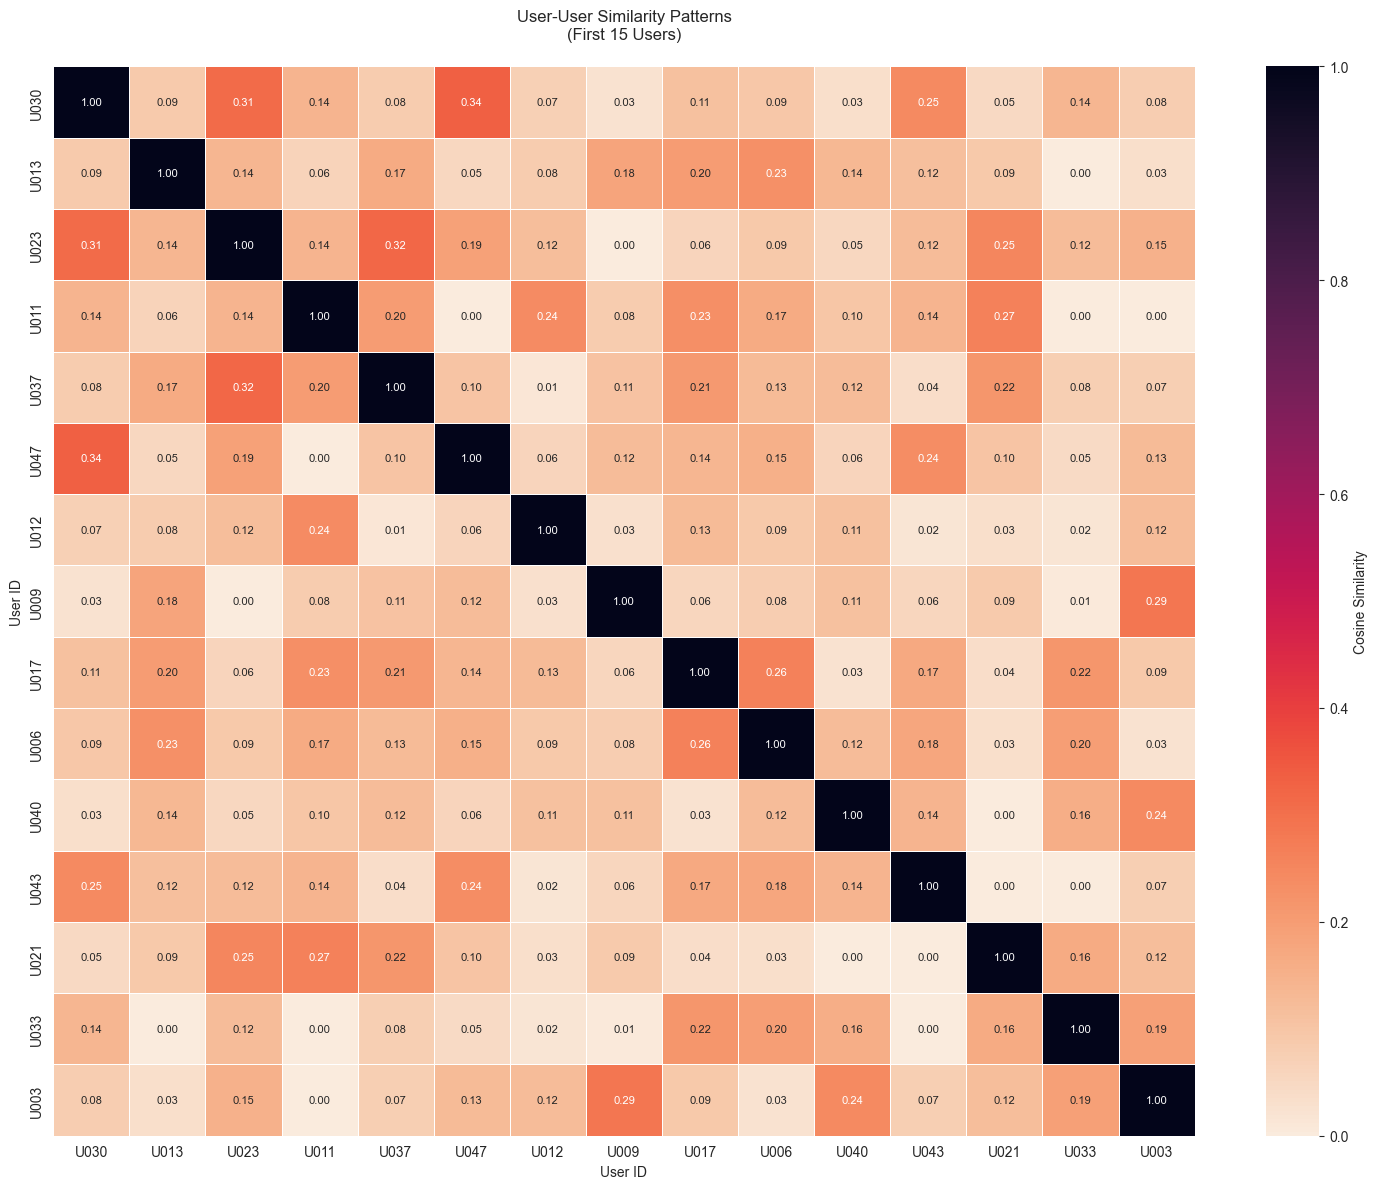

In [36]:
plt.figure(figsize=(15, 12))
sns.heatmap(
    user_sim_df.iloc[:15, :15],
    cmap="rocket_r",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 8},
    cbar_kws={"label": "Cosine Similarity"}
)

plt.title("User-User Similarity Patterns\n(First 15 Users)", pad=20)
plt.xlabel("User ID")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

###Product Network Graph

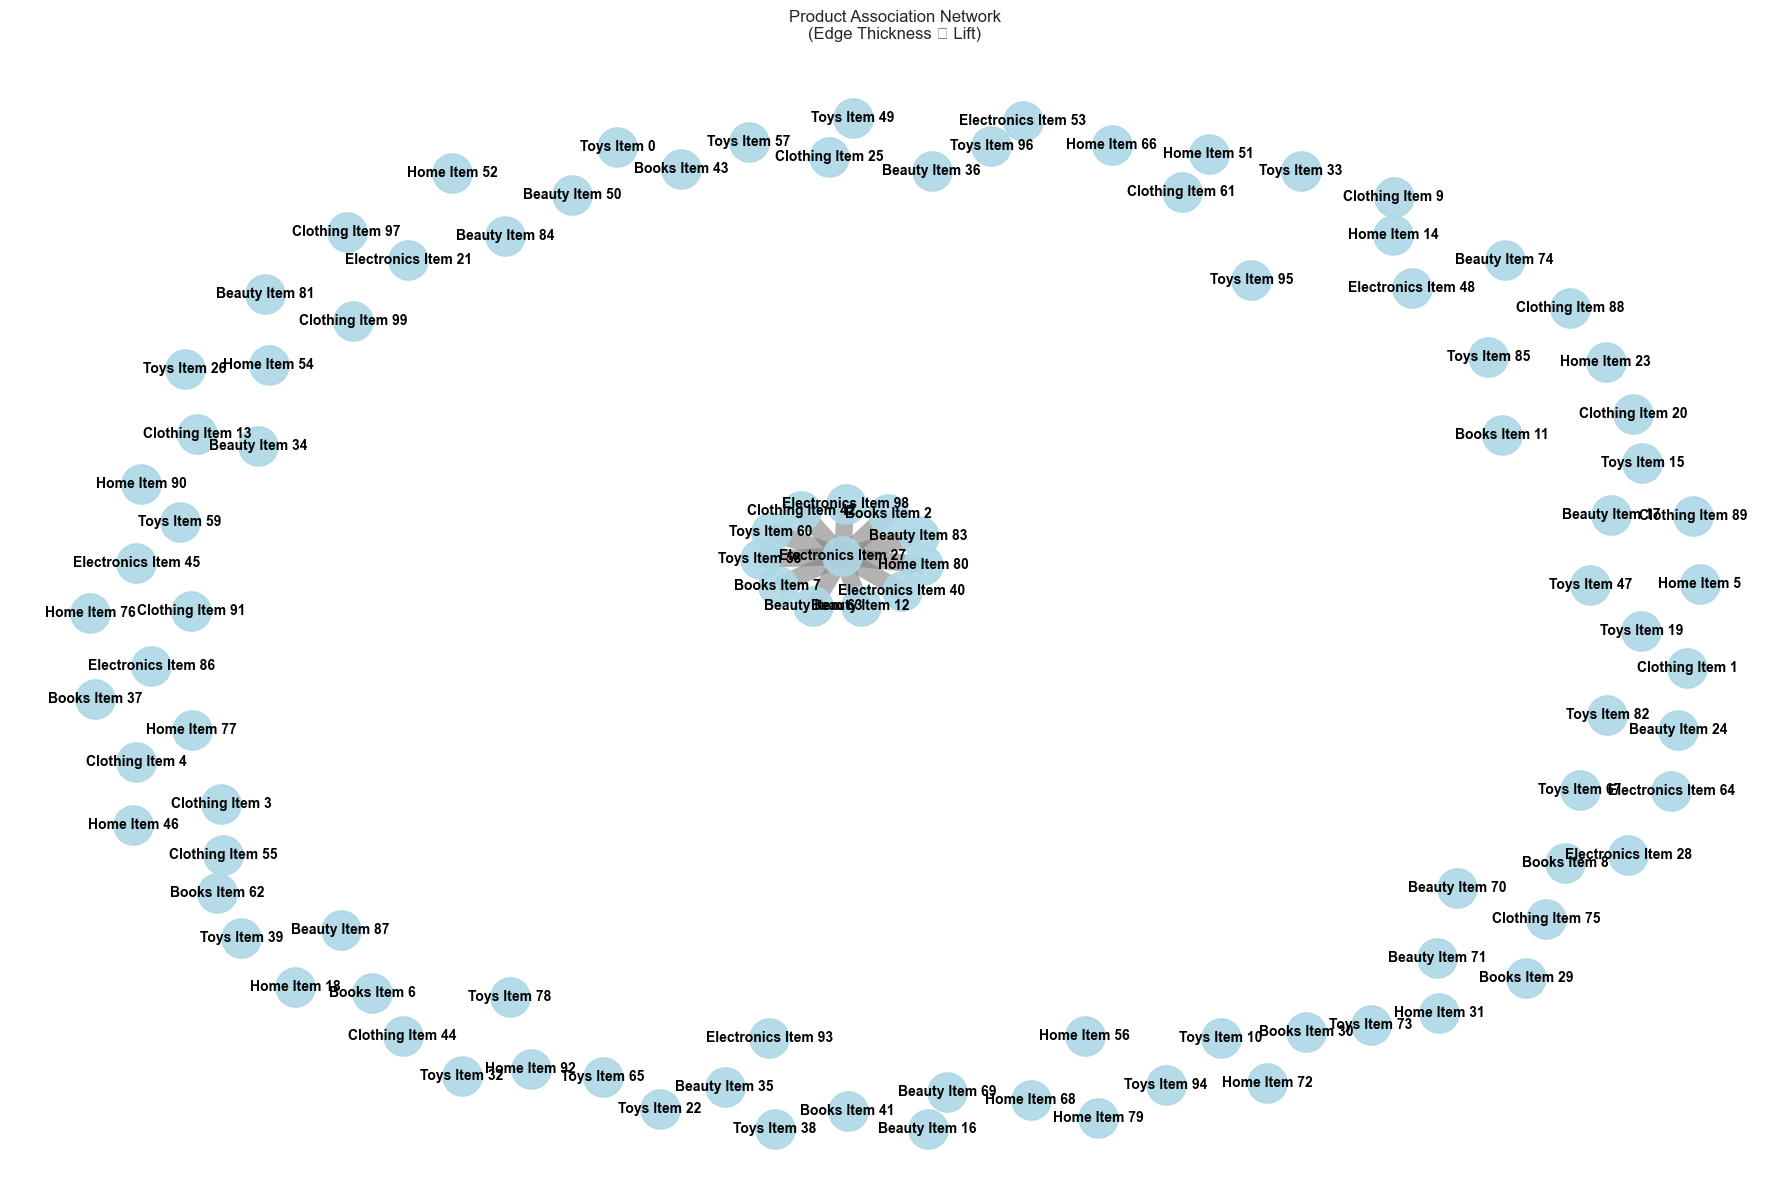

In [37]:
# Create product co-occurrence graph
G = nx.Graph()

# Add nodes (products)
for pid in transaction_df.columns:
    G.add_node(pid, name=product_data.loc[product_data['ProductID'] == pid, 'ProductName'].values[0])

# Add edges (co-occurrences)
for _, row in rules.head(15).iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']:
            G.add_edge(ant, cons, weight=row['lift'])

# Draw graph
plt.figure(figsize=(18, 12))
pos = nx.spring_layout(G, k=0.5)

nx.draw_networkx_nodes(
    G, pos,
    node_size=800,
    node_color='lightblue',
    alpha=0.9
)

nx.draw_networkx_edges(
    G, pos,
    width=[d['weight']*0.5 for _,_,d in G.edges(data=True)],
    edge_color='gray',
    alpha=0.6
)

nx.draw_networkx_labels(
    G, pos,
    labels={n: G.nodes[n]['name'] for n in G.nodes},
    font_size=10,
    font_weight='bold'
)

plt.title("Product Association Network\n(Edge Thickness ∝ Lift)", pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


### Visualization of Top-10 Frequent Itemsets

To better understand which products are commonly bought together, we visualize the top-10 frequent itemsets discovered using the Apriori algorithm.


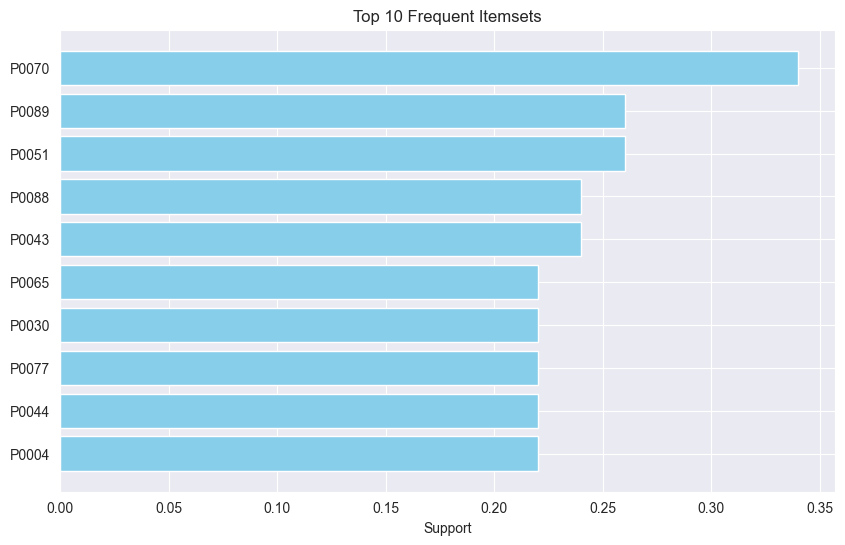

In [38]:

import matplotlib.pyplot as plt

# Assuming `frequent_itemsets` DataFrame is already available
top_10 = frequent_itemsets.sort_values(by='support', ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.barh([' & '.join(item) for item in top_10['itemsets']], top_10['support'], color='skyblue')
plt.xlabel('Support')
plt.title('Top 10 Frequent Itemsets')
plt.gca().invert_yaxis()
plt.show()



### User Similarity Heatmap

We compute the cosine similarity between users based on their interactions. The heatmap below shows how similar each user is to others, which is crucial for making collaborative filtering recommendations.


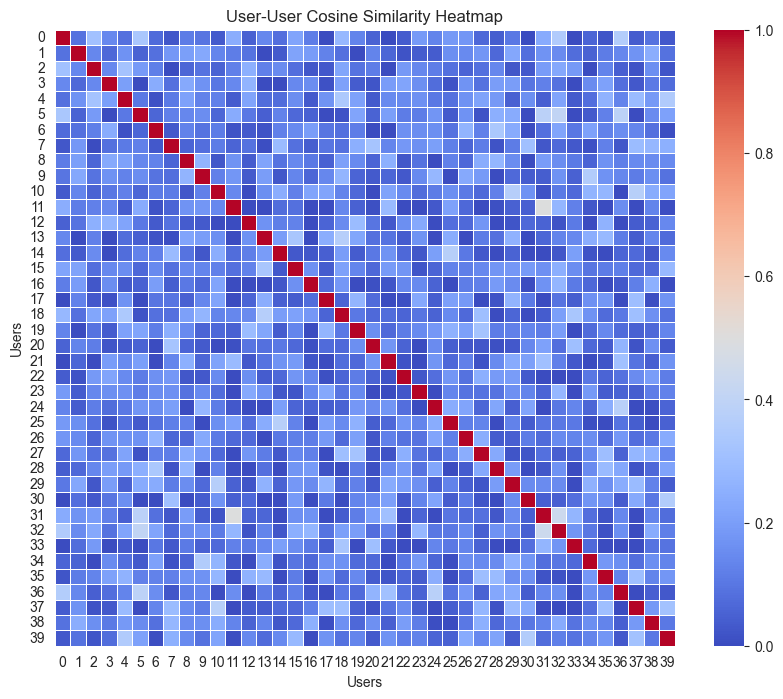

In [39]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming this is the correct variable holding the cosine similarity DataFrame
if 'user_similarity' in locals():
    plt.figure(figsize=(10, 8))
    sns.heatmap(user_similarity, cmap='coolwarm', linewidths=0.5)
    plt.title('User-User Cosine Similarity Heatmap')
    plt.xlabel('Users')
    plt.ylabel('Users')
    plt.show()
else:
    print("user_similarity_df is not defined. Make sure similarity matrix is computed before this cell.")